# Data Preparation

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score

path = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(path)

df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [58]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [59]:
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical = df.select_dtypes(include=['object']).columns.tolist()

In [60]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [61]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [62]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Q1

In [63]:
y_train, y_val, y_test = df_train['converted'].values, df_val['converted'].values, df_test['converted'].values
df_train, df_val, df_test = df_train.drop(columns=['converted']), df_val.drop(columns=['converted']), df_test.drop(columns=['converted'])

In [64]:
# only check numerical features that exist in df_train (converted was removed earlier)
features_to_check = [f for f in numerical if f in df_train.columns]
for feature in features_to_check:
    scores = df_train[feature].values
    auc = roc_auc_score(y_train, scores)
    note = ''
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
        note = ' (inverted)'
    print(f"{feature:30s} AUC = {auc:.3f}{note}")
print()


number_of_courses_viewed       AUC = 0.764
annual_income                  AUC = 0.552
interaction_count              AUC = 0.738
lead_score                     AUC = 0.614



# Q2

In [65]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
probs_val = model.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val, probs_val)
print("Q2: Validation AUC (round 3):", round(auc_val, 3))
print()

Q2: Validation AUC (round 3): 0.817



# Q3

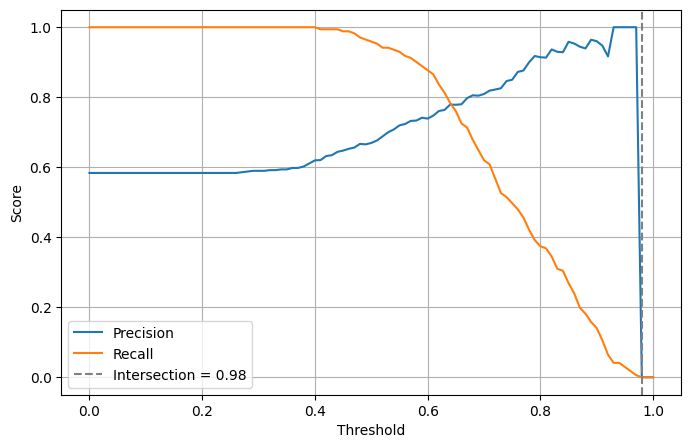

Threshold where precision ≈ recall: 0.98


In [66]:
import matplotlib.pyplot as plt
ths = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
for t in ths:
    preds = (probs_val >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds))

precisions = np.array(precisions)
recalls = np.array(recalls)

# find threshold where precision ≈ recall
idx = np.argmin(np.abs(precisions - recalls))
threshold = round(ths[idx], 3)

plt.figure(figsize=(8,5))
plt.plot(ths, precisions, label='Precision')
plt.plot(ths, recalls, label='Recall')
plt.axvline(ths[idx], color='gray', linestyle='--', label=f'Intersection = {threshold}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

print("Threshold where precision ≈ recall:", threshold)

# Q4

In [67]:
f1 = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1)
print("Q4: best threshold (max F1):", round(ths[best_idx], 2))
print()

Q4: best threshold (max F1): 0.57



# Q5

In [68]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs = []
for train_idx, val_idx in kf.split(df_full_train):
    df_tr = df_full_train.iloc[train_idx].copy()
    df_va = df_full_train.iloc[val_idx].copy()
    y_tr = df_tr['converted'].values; y_va = df_va['converted'].values
    df_tr = df_tr.drop(columns=['converted'])
    df_va = df_va.drop(columns=['converted'])
    dv = DictVectorizer(sparse=False)
    X_tr = dv.fit_transform(df_tr.to_dict('records'))
    X_va = dv.transform(df_va.to_dict('records'))
    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_tr, y_tr)
    aucs.append(roc_auc_score(y_va, model_cv.predict_proba(X_va)[:,1]))
aucs = np.array(aucs)
print("Q5: std of AUCs across folds:", np.std(aucs))
print("Fold AUCs:", np.round(aucs, 3))
print()

Q5: std of AUCs across folds: 0.03580711942905165
Fold AUCs: [0.806 0.871 0.775 0.802 0.856]



# Q6

In [70]:
Cs = [1e-6, 0.001, 1]
res = {}
for C in Cs:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_tr = df_full_train.iloc[train_idx].copy()
        df_va = df_full_train.iloc[val_idx].copy()
        y_tr = df_tr['converted'].values; y_va = df_va['converted'].values
        df_tr = df_tr.drop(columns=['converted'])
        df_va = df_va.drop(columns=['converted'])
        dv = DictVectorizer(sparse=False)
        X_tr = dv.fit_transform(df_tr.to_dict('records'))
        X_va = dv.transform(df_va.to_dict('records'))
        model_c = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_c.fit(X_tr, y_tr)
        scores.append(roc_auc_score(y_va, model_c.predict_proba(X_va)[:,1]))
    res[C] = (np.mean(scores), np.std(scores))

print("Q6: mean and std for each C (round 3):")
for C,(m,s) in res.items():
    print(f"C={C:<9} mean={m:.3f} std={s:.3f}")

# choose best C: highest mean, tie-breaker = lowest std, then smallest C
best = sorted(res.items(), key=lambda x:(-round(x[1][0],3), round(x[1][1],3), x[0]))[0][0]
print("Q6: best C:", best)
# ...existing code...

Q6: mean and std for each C (round 3):
C=1e-06     mean=0.560 std=0.024
C=0.001     mean=0.867 std=0.029
C=1         mean=0.822 std=0.036
Q6: best C: 0.001
